In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


# How to use the D2 Algorithm function:
# Set your thresholds (these need to be tuned based on the specific data)
# T1 = 3 * np.std(data['wf_i'][1][2500:2900])  # Example: 3 times the std of the noise baseline
# T2 = 0.053320  # This needs to be tuned based on your data

# detected_peaks = process_waveforms(waveforms, T1, T2)

def derivative_peak_detection(waveform, T1, T2):
    """
    Derivative-based peak detection algorithm.
    
    Args:
    waveform (np.array): Input waveform with n points.
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: Indices of detected peaks.
    """
    n = len(waveform)
    Output = []
    D1 = np.zeros(n)
    D2 = np.zeros(n)
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
        
        D1[i] = max(waveform[i] - waveform[i-1], 0)
        D2[i] = max(D1[i] - D1[i-1], 0)
        
        if D2[i] > 0:
            Int[i] = Int[i-1] + D2[i]
        elif Int[i-1] > T2:
            Output.append(i-1)
            Int[i] = 0  # Reset integration after detecting a peak
        else:
            Int[i] = 0  # Reset integration if no peak detected
    
    return Output


def process_waveforms(waveforms, T1, T2):
    """
    Process multiple waveforms using the derivative algorithm.

    Returns:
        list: List of detected peak indices for each waveform.
    """
    all_peaks = []
    for waveform in tqdm(waveforms, desc="Processing waveforms", unit="waveform"):
        peaks = derivative_peak_detection(waveform, T1, T2)
        all_peaks.append(peaks)
    return all_peaks

def d1_peak_detection(waveform, t1, t2):
    """
    D1 algorithm for real-time peak detection.
    
    Args:
        waveform (np.array): Input waveform with n points.
        t1 (float): Threshold for short-term gradient V(i+1) - V(i).
        t2 (float): Threshold for medium-term gradient V(i+2) - V(i).
    
    Returns:
        int: Number of detected peaks.
    """
    n = len(waveform)
    
    peak_count = 0
    in_peak = False
    
    # Process each point in real-time fashion
    for i in range(n - 2):  # We need i+2 to be valid
        # Calculate gradients
        short_gradient = waveform[i + 1] - waveform[i]
        medium_gradient = waveform[i + 2] - waveform[i]
        
        # Determine signal (1 or 0)
        signal = 1 if (short_gradient > t1 or medium_gradient > t2) else 0
        
        # Peak detection logic
        if signal == 1 and not in_peak:
            # Start of a new peak
            in_peak = True
        elif signal == 0 and in_peak:
            # End of current peak
            in_peak = False
            peak_count += 1
    
    # Handle case where waveform ends while in a peak
    if in_peak:
        peak_count += 1
    
    return peak_count

def process_waveforms_d1(waveforms, t1, t2):
    """
    Process multiple waveforms using the D1 algorithm.
    
    Args:
        waveforms: Array of waveforms to process.
        t1 (float): Threshold for short-term gradient.
        t2 (float): Threshold for medium-term gradient.
    
    Returns:
        list: List of detected peak counts for each waveform.
    """
    peak_counts = []
    # for waveform in tqdm(waveforms, desc="Processing waveforms with D1", unit="waveform"):
    for waveform in waveforms:
        count = d1_peak_detection(waveform, t1, t2)
        peak_counts.append(count)
    return peak_counts

# Extract true peaks from labels

def extract_true_peaks_from_labels(testdata):
    """
    Extract true peak positions from labels where tag_values = 1 or 2.
    
    Returns:
        list: List of true peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1 and 2
        peak_mask = (tag_values[i] == 1) | (tag_values[i] == 2)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

def extract_true_primary_peaks_from_labels(testdata):
    """
    Extract true primary peak positions from labels where tag_values = 1.
    
    Returns:
        list: List of true primary peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true primary peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1
        peak_mask = (tag_values[i] == 1)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

# Fixed Clusterization Method

def estimate_primary_from_cluster_window(detected_peaks, b, c, d):
    """
    Estimate the number of primary ionizations per waveform by merging nearby peaks in a sliding window.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Number of units to look forward in time window.
        c (float): Normalization factor (divides peak count in window).
        d (float): Maximum number of peaks in window.
    Returns:
        list: Estimated number of primary ionizations (float) for each waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:

        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current
            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d*c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts

def collect_cluster_peaks(detected_peaks, b, c, d):
    """
    For each waveform, return a list of peak lists used in each cluster count step.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Window size to look forward.
        c (float): Normalization factor.
        d (float): Maximum number of peaks allowed in window.
    
    Returns:
        list of lists: Each inner list contains the peak values used at each cluster step.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current

            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            # Determine how many peaks to take from this cluster
            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            # Store the first n peaks in this cluster (or fewer if not enough)
            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def find_best_indices_3d(data, mode="mean"):
    if mode == "mean":
        idx = np.unravel_index(np.argmin(np.abs(data)), data.shape)
    elif mode == "std":
        idx = np.unravel_index(np.argmin(data), data.shape)
    return idx

def plot_heatmap_2d_slice(data_3d, d_idx, title, x_labels, y_labels, x_name, y_name, cmap='viridis', highlight=None):
    data = data_3d[:, :, d_idx]
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data, origin='lower', cmap=cmap,
                    extent=[x_labels[0], x_labels[-1], y_labels[0], y_labels[-1]],
                    aspect='auto')

    cbar = plt.colorbar(im, format="%.4f")
    cbar.ax.tick_params(labelsize=10)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f"{title} (d = {d_values[d_idx]})")

    if highlight:
        i, j, _ = highlight
        x_val = x_labels[j]
        y_val = y_labels[i]
        plt.plot(x_val, y_val, 'ro', markersize=8, label='Best Point')
        plt.legend()

    plt.tight_layout()
    plt.show()


# Adaptive Clusterization Method

import itertools

region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 1550),
        'r4': (1550, 3000),
    }
# region_bounds = {
    #     'r1': (0, 130),
    #     'r2': (130, 1600),
    #     'r3': (1600, 3000),
    # }

def estimate_primary_from_cluster_window_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Adaptive estimation of primary ionizations per waveform using different parameters for different time regions.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Keys are region names ('r1', 'r2', ...), values are parameter values.
    
    Returns:
        list: Estimated primary ionizations per waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]

            # Determine region
            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d * c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts


def collect_cluster_peaks_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Collect cluster peaks per waveform with region-adapted parameters.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Region-specific parameter mappings.

    Returns:
        list of lists: Each inner list contains peak lists used in each cluster.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]

            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def scan_adaptive_parameters_region_wise(detected_peaks, true_primary_peaks):
    """
    Scan optimal parameters for each region using true primary peaks.
    
    Args:
        detected_peaks (list): List of detected peak positions for each waveform
        true_primary_peaks (list): List of true primary peak positions for each waveform (from extract_true_primary_peaks_from_labels)
    """

    b_values = np.arange(1, 100, 1)
    c_values = np.arange(0.8, 2.0, 0.1)
    d_values = np.arange(1, 6, 1)
    
    best_params = {}
    region_results = {}
    
    for region, (low, high) in region_bounds.items():
        print(f"Scanning parameters for region {region} ({low}-{high})")
        
        region_detected_peaks = []
        region_true_counts = []
        
        for i, peaks in enumerate(detected_peaks):
            region_peaks = [p for p in peaks if low <= p < high]
            true_peaks_in_region = [p for p in true_primary_peaks[i] if low <= p < high]
            true_count_in_region = len(true_peaks_in_region)
            if region_peaks:
                region_detected_peaks.append(region_peaks)
                region_true_counts.append(true_count_in_region)
        
        if not region_detected_peaks:
            best_params[region] = {'b': 10, 'c': 1.0, 'd': 2}
            region_results[region] = float('inf')
            print(f"No detected peaks in region {region}, using default parameters")
            continue
        
        region_true_counts = np.array(region_true_counts)
        
        best_score = float('inf')
        best_region_params = None
        
        for b, c, d in tqdm(list(itertools.product(b_values, c_values, d_values)), 
                           desc=f"Region {region}"):
            
            temp_b_map = {r: 10 for r in region_bounds.keys()}
            temp_c_map = {r: 1.0 for r in region_bounds.keys()}
            temp_d_map = {r: 2 for r in region_bounds.keys()}
            
            temp_b_map[region] = int(b)
            temp_c_map[region] = float(c)
            temp_d_map[region] = int(d)
            
            estimated_counts = []
            for peaks in region_detected_peaks:
                count = estimate_single_region_count(peaks, b, c, d)
                estimated_counts.append(count)
            
            estimated_counts = np.array(estimated_counts)
            
            # Calculate relative errors: (estimated - true) / true
            with np.errstate(divide='ignore', invalid='ignore'):
                relative_errors = (estimated_counts - region_true_counts) / region_true_counts
                # Handle division by zero and invalid values
                relative_errors = relative_errors[np.isfinite(relative_errors)]
            
            # Calculate score based on relative errors
            if len(relative_errors) > 0:
                score = np.abs(np.mean(relative_errors))  # Mean squared relative error
            else:
                score = float('inf')  # If no valid relative errors, set high score
            
            if score < best_score:
                best_score = score
                best_region_params = {'b': b, 'c': c, 'd': d}
                # print(f"Best score: {score:.4f}")
                # print(f"Best params: {best_region_params}")
        
        best_params[region] = best_region_params
        region_results[region] = best_score
        print(f"Best params for {region}: {best_region_params}, Score: {best_score:.4f}")
    
    return best_params, region_results

def estimate_single_region_count(peaks, b, c, d):
    if not peaks:
        return 0.0
    
    peaks = sorted(peaks)
    remaining_peaks = peaks.copy()
    count = 0.0
    
    while remaining_peaks:
        current = remaining_peaks[0]
        window_start = current
        window_end = current + b
        
        cluster = [p for p in remaining_peaks if window_start <= p <= window_end]
        
        if len(cluster) <= c:
            count += 1
        elif d * c > len(cluster) > c:
            count += len(cluster) / c
        else:
            count += d
        
        remaining_peaks = [p for p in remaining_peaks if p not in cluster]
    
    return count

def run_adaptive_parameter_optimization(detected_peak, true_primary_peaks):
    """Complete adaptive parameter optimization workflow"""
    
    print("Starting adaptive parameter scanning...")
    
    # Step 1: Parameter scanning
    best_params, region_results = scan_adaptive_parameters_region_wise(
        detected_peak, 
        true_primary_peaks
    )
    
    # Step 2: Format conversion
    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}
    
    # Step 3: Final prediction
    adaptive_estimates = estimate_primary_from_cluster_window_adaptive(
        detected_peak, b_map, c_map, d_map
    )
    
    # Step 4: Compare with fixed parameter method
    # Use default fixed parameters
    fixed_estimates = estimate_primary_from_cluster_window(
        detected_peak, b=24, c=1.60, d=2
    )
    # fixed_estimates = estimate_primary_from_cluster_window(
    #     detected_peak, b=69, c=0.899, d=3
    # )

    true_primary_peak_counts = [len(peaks) for peaks in true_primary_peaks]
    true_primary_peak_counts = np.array(true_primary_peak_counts)
    adaptive_estimates = np.array(adaptive_estimates)
    fixed_estimates = np.array(fixed_estimates)
    
    
    # Step 5: Performance comparison
    adaptive_mae = np.mean(np.abs(adaptive_estimates - true_primary_peak_counts))
    fixed_mae = np.mean(np.abs(fixed_estimates - true_primary_peak_counts))
    
    print(f"\nPerformance comparison:")
    print(f"Adaptive method MAE: {adaptive_mae:.4f}")
    print(f"Fixed parameter method MAE: {fixed_mae:.4f}")
    print(f"Improvement: {((fixed_mae - adaptive_mae) / fixed_mae * 100):.2f}%")
    
    # Step 6: Visualization
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Parameter distribution
    plt.subplot(2, 2, 1)
    regions = list(best_params.keys())
    b_values = [best_params[r]['b'] for r in regions]
    plt.bar(regions, b_values)
    plt.title('Optimal b parameters by region')
    plt.ylabel('b value')
    
    plt.subplot(2, 2, 2)
    c_values = [best_params[r]['c'] for r in regions]
    plt.bar(regions, c_values)
    plt.title('Optimal c parameters by region')
    plt.ylabel('c value')
    
    # Subplot 3: Prediction comparison
    plt.subplot(2, 2, 3)
    adaptive_corr = np.corrcoef(true_primary_peak_counts, adaptive_estimates)[0, 1]
    fixed_corr = np.corrcoef(true_primary_peak_counts, fixed_estimates)[0, 1]

    plt.scatter(true_primary_peak_counts, adaptive_estimates, alpha=0.6, label=f'Adaptive (R={adaptive_corr:.3f})')
    plt.scatter(true_primary_peak_counts, fixed_estimates, alpha=0.6, label=f'Fixed (R={fixed_corr:.3f})')
    plt.plot([0, max(true_primary_peak_counts)], [0, max(true_primary_peak_counts)], 'r--')
    plt.xlabel('True Counts')
    plt.ylabel('Estimated Counts')
    plt.legend()
    plt.title('Prediction accuracy comparison')
    
    # Subplot 4: Error distribution
    plt.subplot(2, 2, 4)
    with np.errstate(divide='ignore', invalid='ignore'):
        adaptive_rel_errors = (np.array(adaptive_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        fixed_rel_errors = (np.array(fixed_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        adaptive_rel_errors = adaptive_rel_errors[np.isfinite(adaptive_rel_errors)]
        fixed_rel_errors = fixed_rel_errors[np.isfinite(fixed_rel_errors)]

    # Calculate mean and std for relative errors
    adaptive_rel_mean = np.mean(adaptive_rel_errors)
    adaptive_rel_std = np.std(adaptive_rel_errors)
    fixed_rel_mean = np.mean(fixed_rel_errors)
    fixed_rel_std = np.std(fixed_rel_errors)

    plt.hist(adaptive_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Adaptive (μ={adaptive_rel_mean:.3f}, σ={adaptive_rel_std:.3f})', density=False)
    plt.hist(fixed_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Fixed (μ={fixed_rel_mean:.3f}, σ={fixed_rel_std:.3f})', density=False)
    plt.xlabel('Relative Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Relative error distribution comparison')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': best_params,
        'b_map': b_map,
        'c_map': c_map,
        'd_map': d_map,
        'adaptive_estimates': adaptive_estimates,
        'region_results': region_results
    }

In [2]:
# Loading data
testdata = load_data("./processed_data_test/",
                     ["batch_0.npz",
                    #   "batch_1.npz",
                    #   "batch_2.npz",
                    #   "batch_3.npz",
                    #   "batch_4.npz",
                    ])


pion_data = load_data("./processed_data_test_clusterization/pion/",
                     ["batch_5p0.npz",
                      "batch_7p5.npz",
                      "batch_10p0.npz",
                      "batch_12p5.npz",
                      "batch_15p0.npz",
                      "batch_17p5.npz",
                      "batch_20p0.npz"
                    ])

kaon_data = load_data("./processed_data_test_clusterization/kaon/",
                     ["batch_5p0.npz",
                      "batch_7p5.npz",
                      "batch_10p0.npz",
                      "batch_12p5.npz",
                      "batch_15p0.npz",
                      "batch_17p5.npz",
                      "batch_20p0.npz"
                    ])

In [3]:
def create_momentum_subsets(data, particle_name):

    unique_momenta = np.unique(data['mom'])
    momentum_subsets = {}
    
    print(f"\n{particle_name} data - Available momenta: {unique_momenta}")
    
    for mom_value in unique_momenta:
        mom_mask = data['mom'] == mom_value
        
        subset = {}
        for key in data.keys():
            subset[key] = data[key][mom_mask]
        
        momentum_subsets[mom_value] = subset
        
        print(f"  Momentum {mom_value}: {np.sum(mom_mask)} events")
    
    return momentum_subsets

pion_momentum_subsets = create_momentum_subsets(pion_data, "Pion")

kaon_momentum_subsets = create_momentum_subsets(kaon_data, "Kaon")


# pion_5GeV = pion_momentum_subsets[5.0]
# pion_10GeV = pion_momentum_subsets[10.0]

# kaon_5GeV = kaon_momentum_subsets[5.0]
# kaon_10GeV = kaon_momentum_subsets[10.0]


Pion data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
  Momentum 5.0: 100000 events
  Momentum 7.5: 100000 events
  Momentum 10.0: 100000 events
  Momentum 12.5: 100000 events
  Momentum 15.0: 100000 events
  Momentum 17.5: 100000 events
  Momentum 20.0: 100000 events

Kaon data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
  Momentum 5.0: 100000 events
  Momentum 7.5: 100000 events
  Momentum 10.0: 100000 events
  Momentum 12.5: 100000 events
  Momentum 15.0: 100000 events
  Momentum 17.5: 100000 events
  Momentum 20.0: 100000 events


In [4]:
def process_momentum_subsets_FCA(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms(wf_subset, T1, T2)
        primary_counts = estimate_primary_from_cluster_window(detected_peaks, b=24, c=1.60, d=2)
        primary_counts = np.array(primary_counts)
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_D1(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms_d1(wf_subset, T1, T2)
        primary_counts = np.array(detected_peaks)
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts) 
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_D2(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms(wf_subset, T1, T2)
        primary_counts = np.array([len(peaks) for peaks in detected_peaks])
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts) 
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_ACA(particle_subsets, particle_name, T1, T2, max_events=5000):

    region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 1550),
        'r4': (1550, 3000),
    }
    
    best_params = {
        'r1': {'b': 8, 'c': 0.8, 'd': 2},
        'r2': {'b': 32, 'c': 1.0, 'd': 5},
        'r3': {'b': 67, 'c': 1.4, 'd': 2},
        'r4': {'b': 99, 'c': 0.8, 'd': 1}
    }
    
    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}
    
    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms(wf_subset, T1, T2)
        primary_counts = estimate_primary_from_cluster_window_adaptive(
            detected_peaks, b_map, c_map, d_map
        )
        primary_counts = np.array(primary_counts)
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

In [5]:
T1 = 3 * np.std(testdata['wf_i'][1][2500:2900])
T2 = 0.053320


detected_peaks_pion = process_waveforms(pion_data['wf_i'], T1, T2)
primary_counts_fixed_pion = estimate_primary_from_cluster_window(detected_peaks_pion, b=24, c=1.60, d=2)

detected_peaks_kaon = process_waveforms(kaon_data['wf_i'], T1, T2)
primary_counts_fixed_kaon = estimate_primary_from_cluster_window(detected_peaks_kaon, b=24, c=1.60, d=2)

primary_counts_fixed_pion = np.array(primary_counts_fixed_pion)
primary_counts_fixed_kaon = np.array(primary_counts_fixed_kaon)

mean_pion = np.mean(primary_counts_fixed_pion)
mean_kaon = np.mean(primary_counts_fixed_kaon)
std_pion = np.std(primary_counts_fixed_pion)
std_kaon = np.std(primary_counts_fixed_kaon)

plt.figure(figsize=(10, 8))
plt.hist(primary_counts_fixed_pion, bins=100, alpha=0.5, label=f'Pion, Mean: {mean_pion:.3f}, Std: {std_pion:.3f}')
plt.hist(primary_counts_fixed_kaon, bins=100, alpha=0.5, label=f'Kaon, Mean: {mean_kaon:.3f}, Std: {std_kaon:.3f}')
plt.xlabel('Primary Counts')
plt.ylabel('Frequency')
plt.title('Primary Counts Distribution')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


len_scaler = 1000/18 #18mmx18mm for the cell size, 1000mm for the track length.

kp_seperation = np.abs(mean_pion - mean_kaon)/((std_pion + std_kaon)/2) * len_scaler

print(f'Pion-Kaon Seperation Power: {kp_seperation:.3f}')







Processing waveforms:   2%|▏         | 10698/700000 [00:21<23:10, 495.66waveform/s]


KeyboardInterrupt: 

In [5]:
T1 = 3 * np.std(testdata['wf_i'][1][2500:2900])
T2 = 0.053320


print("Processing Pion data...")
pion_momenta, mean_pion, std_pion = process_momentum_subsets_FCA(
    pion_momentum_subsets, "Pion", T1, T2, max_events=5000
)

print("\nProcessing Kaon data...")
kaon_momenta, mean_kaon, std_kaon = process_momentum_subsets_FCA(
    kaon_momentum_subsets, "Kaon", T1, T2, max_events=5000
)

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)

print(f"Pion momenta: {pion_momenta}")
print(f"Pion means:   {mean_pion}")
print(f"Pion stds:    {std_pion}")

print(f"\nKaon momenta: {kaon_momenta}")
print(f"Kaon means:   {mean_kaon}")
print(f"Kaon stds:    {std_kaon}")

Processing Pion data...
Processing Pion momentum 5.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 502.13waveform/s]


  Mean: 25.477, Std: 7.297
Processing Pion momentum 7.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 488.17waveform/s]


  Mean: 26.428, Std: 7.357
Processing Pion momentum 10.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 479.47waveform/s]


  Mean: 26.801, Std: 7.133
Processing Pion momentum 12.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 473.58waveform/s]


  Mean: 27.347, Std: 7.372
Processing Pion momentum 15.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 461.29waveform/s]


  Mean: 27.614, Std: 7.322
Processing Pion momentum 17.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 464.65waveform/s]


  Mean: 27.745, Std: 7.206
Processing Pion momentum 20.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 462.46waveform/s]


  Mean: 27.770, Std: 7.246

Processing Kaon data...
Processing Kaon momentum 5.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 536.74waveform/s]


  Mean: 22.709, Std: 7.316
Processing Kaon momentum 7.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 522.01waveform/s]


  Mean: 23.541, Std: 7.503
Processing Kaon momentum 10.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 518.87waveform/s]


  Mean: 24.058, Std: 7.131
Processing Kaon momentum 12.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 515.97waveform/s]


  Mean: 24.697, Std: 7.183
Processing Kaon momentum 15.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 512.46waveform/s]


  Mean: 24.960, Std: 7.334
Processing Kaon momentum 17.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 502.60waveform/s]


  Mean: 25.356, Std: 7.167
Processing Kaon momentum 20.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 498.50waveform/s]

  Mean: 25.656, Std: 7.218

RESULTS SUMMARY
Pion momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Pion means:   [25.4775   26.4285   26.80055  27.347175 27.614375 27.7448   27.76995 ]
Pion stds:    [7.2974135  7.35708886 7.13252898 7.37241549 7.32203713 7.20617993
 7.24584076]

Kaon momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Kaon means:   [22.709225 23.541025 24.0584   24.69735  24.9604   25.35645  25.65615 ]
Kaon stds:    [7.31648715 7.50292285 7.13096124 7.18308581 7.33428042 7.16678665
 7.21781812]


In [6]:
T1 = 3 * np.std(testdata['wf_i'][1][2500:2900])
T2 = 0.053320


print("Processing Pion data...")
pion_momenta_ACA, mean_pion_ACA, std_pion_ACA = process_momentum_subsets_ACA(
    pion_momentum_subsets, "Pion", T1, T2, max_events=5000
)

print("\nProcessing Kaon data...")
kaon_momenta_ACA, mean_kaon_ACA, std_kaon_ACA = process_momentum_subsets_ACA(
    kaon_momentum_subsets, "Kaon", T1, T2, max_events=5000
)

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)

print(f"Pion momenta: {pion_momenta}")
print(f"Pion means:   {mean_pion}")
print(f"Pion stds:    {std_pion}")

print(f"\nKaon momenta: {kaon_momenta}")
print(f"Kaon means:   {mean_kaon}")
print(f"Kaon stds:    {std_kaon}")

Processing Pion data...
Processing Pion momentum 5.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 499.36waveform/s]


  Mean: 24.968, Std: 5.928
Processing Pion momentum 7.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 488.49waveform/s]


  Mean: 25.883, Std: 5.931
Processing Pion momentum 10.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 482.90waveform/s]


  Mean: 26.327, Std: 5.840
Processing Pion momentum 12.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 479.21waveform/s]


  Mean: 26.844, Std: 5.824
Processing Pion momentum 15.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 474.56waveform/s]


  Mean: 26.982, Std: 5.806
Processing Pion momentum 17.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 464.60waveform/s]


  Mean: 27.178, Std: 5.852
Processing Pion momentum 20.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 467.81waveform/s]


  Mean: 27.264, Std: 5.885

Processing Kaon data...
Processing Kaon momentum 5.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 548.74waveform/s]


  Mean: 22.285, Std: 5.936
Processing Kaon momentum 7.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 530.48waveform/s]


  Mean: 23.082, Std: 6.038
Processing Kaon momentum 10.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 524.23waveform/s]


  Mean: 23.748, Std: 5.926
Processing Kaon momentum 12.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 514.61waveform/s]


  Mean: 24.336, Std: 5.855
Processing Kaon momentum 15.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 510.90waveform/s]


  Mean: 24.560, Std: 5.917
Processing Kaon momentum 17.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 503.59waveform/s]


  Mean: 25.004, Std: 5.956
Processing Kaon momentum 20.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 498.74waveform/s]


  Mean: 25.246, Std: 5.890

RESULTS SUMMARY
Pion momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Pion means:   [25.4775   26.4285   26.80055  27.347175 27.614375 27.7448   27.76995 ]
Pion stds:    [7.2974135  7.35708886 7.13252898 7.37241549 7.32203713 7.20617993
 7.24584076]

Kaon momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Kaon means:   [22.709225 23.541025 24.0584   24.69735  24.9604   25.35645  25.65615 ]
Kaon stds:    [7.31648715 7.50292285 7.13096124 7.18308581 7.33428042 7.16678665
 7.21781812]



Separation Power FCA: [0.37885505 0.38862352 0.38449916 0.36409945 0.36216123 0.33233918
 0.29229119]

Separation Power FCA scaled: [14.88283177 15.26657353 15.1045535  14.30317718 14.22703678 13.05551619
 11.48228219]

Separation Power ACA: [0.45224741 0.46808114 0.43828864 0.42938594 0.41330219 0.3682119
 0.34267554]

Separation Power ACA scaled: [17.76595613 18.38796362 17.21760392 16.86787288 16.23604337 14.46472944
 13.46156665]


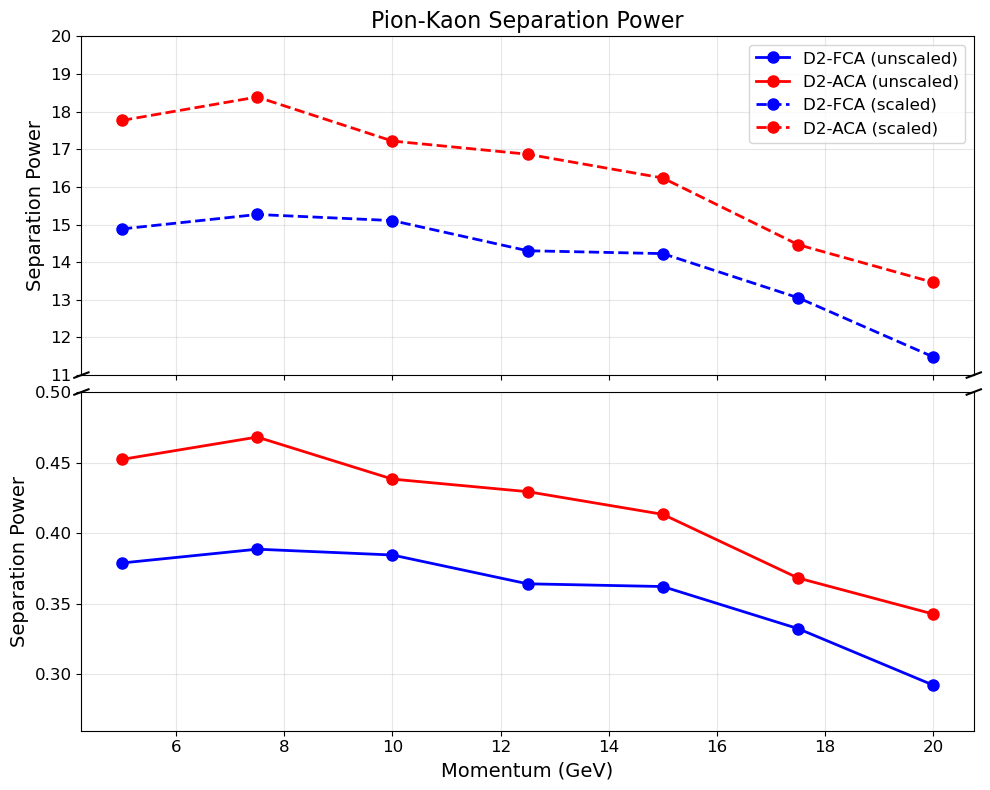

In [7]:
len_scaler = 1000/(18*np.sqrt(2))
kp_separation_FCA = np.abs(mean_pion - mean_kaon) / ((std_pion + std_kaon)/2)
kp_separation_FCA_scaled = kp_separation_FCA * len_scaler

print(f"\nSeparation Power FCA: {kp_separation_FCA}")
print(f"\nSeparation Power FCA scaled: {kp_separation_FCA_scaled}")

kp_separation_ACA = np.abs(mean_pion_ACA - mean_kaon_ACA) / ((std_pion_ACA + std_kaon_ACA)/2)
kp_separation_ACA_scaled = kp_separation_ACA * len_scaler

print(f"\nSeparation Power ACA: {kp_separation_ACA}")
print(f"\nSeparation Power ACA scaled: {kp_separation_ACA_scaled}")

fig, (ax_upper, ax_lower) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 2]})

ax_upper.plot(pion_momenta, kp_separation_FCA, 'bo-', linewidth=2, markersize=8, label='D2-FCA (unscaled)')
ax_upper.plot(pion_momenta_ACA, kp_separation_ACA, 'ro-', linewidth=2, markersize=8, label='D2-ACA (unscaled)')
ax_upper.plot(pion_momenta, kp_separation_FCA_scaled, 'bo--', linewidth=2, markersize=8, label='D2-FCA (scaled)')
ax_upper.plot(pion_momenta_ACA, kp_separation_ACA_scaled, 'ro--', linewidth=2, markersize=8, label='D2-ACA (scaled)')

ax_upper.set_ylim(11, 20)
ax_upper.grid(True, alpha=0.3)
ax_upper.set_ylabel('Separation Power', fontsize=14)
ax_upper.set_title('Pion-Kaon Separation Power', fontsize=16)
ax_upper.tick_params(labelsize=12)
ax_upper.legend(fontsize=12)

ax_lower.plot(pion_momenta, kp_separation_FCA, 'bo-', linewidth=2, markersize=8)
ax_lower.plot(pion_momenta_ACA, kp_separation_ACA, 'ro-', linewidth=2, markersize=8)
ax_lower.plot(pion_momenta, kp_separation_FCA_scaled, 'bo--', linewidth=2, markersize=8)
ax_lower.plot(pion_momenta_ACA, kp_separation_ACA_scaled, 'ro--', linewidth=2, markersize=8)

ax_lower.set_ylim(0.26, 0.5)
ax_lower.grid(True, alpha=0.3)
ax_lower.set_xlabel('Momentum (GeV)', fontsize=14)
ax_lower.set_ylabel('Separation Power', fontsize=14)
ax_lower.tick_params(labelsize=12)

d = 0.008  
kwargs = dict(transform=ax_upper.transAxes, color='k', clip_on=False)
ax_upper.plot((-d, +d), (-d, +d), **kwargs)       
ax_upper.plot((1 - d, 1 + d), (-d, +d), **kwargs)  

kwargs.update(transform=ax_lower.transAxes)  
ax_lower.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax_lower.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()

In [52]:
T1 = 3 * np.std(testdata['wf_i'][1][2500:2900])
T2 = 0.053320

pion_subset = pion_momentum_subsets[10.0]
kaon_subset = kaon_momentum_subsets[10.0]

pion_subset_20GeV = pion_momentum_subsets[20.0]
kaon_subset_20GeV = kaon_momentum_subsets[20.0]

n_events = min(len(kaon_subset['wf_i']), 5000)
pion_wf_subset = pion_subset['wf_i'][:n_events]
kaon_wf_subset = kaon_subset['wf_i'][:n_events]
pion_wf_subset_20GeV = pion_subset_20GeV['wf_i'][:n_events]
kaon_wf_subset_20GeV = kaon_subset_20GeV['wf_i'][:n_events]
        
        
detected_peaks_pion = process_waveforms(pion_wf_subset, T1, T2)
primary_counts_fixed_pion = estimate_primary_from_cluster_window(detected_peaks_pion, b=24, c=1.60, d=2)

detected_peaks_kaon = process_waveforms(kaon_wf_subset, T1, T2)
primary_counts_fixed_kaon = estimate_primary_from_cluster_window(detected_peaks_kaon, b=24, c=1.60, d=2)

detected_peaks_pion_20GeV = process_waveforms(pion_wf_subset_20GeV, T1, T2)
primary_counts_fixed_pion_20GeV = estimate_primary_from_cluster_window(detected_peaks_pion_20GeV, b=24, c=1.60, d=2)

detected_peaks_kaon_20GeV = process_waveforms(kaon_wf_subset_20GeV, T1, T2)
primary_counts_fixed_kaon_20GeV = estimate_primary_from_cluster_window(detected_peaks_kaon_20GeV, b=24, c=1.60, d=2)

primary_counts_fixed_pion = np.array(primary_counts_fixed_pion)
primary_counts_fixed_kaon = np.array(primary_counts_fixed_kaon)
primary_counts_fixed_pion_20GeV = np.array(primary_counts_fixed_pion_20GeV)
primary_counts_fixed_kaon_20GeV = np.array(primary_counts_fixed_kaon_20GeV)

mean_pion = np.mean(primary_counts_fixed_pion)
mean_kaon = np.mean(primary_counts_fixed_kaon)
std_pion = np.std(primary_counts_fixed_pion)
std_kaon = np.std(primary_counts_fixed_kaon)

mean_pion_20GeV = np.mean(primary_counts_fixed_pion_20GeV)
mean_kaon_20GeV = np.mean(primary_counts_fixed_kaon_20GeV)
std_pion_20GeV = np.std(primary_counts_fixed_pion_20GeV)
std_kaon_20GeV = np.std(primary_counts_fixed_kaon_20GeV)

Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 517.02waveform/s]


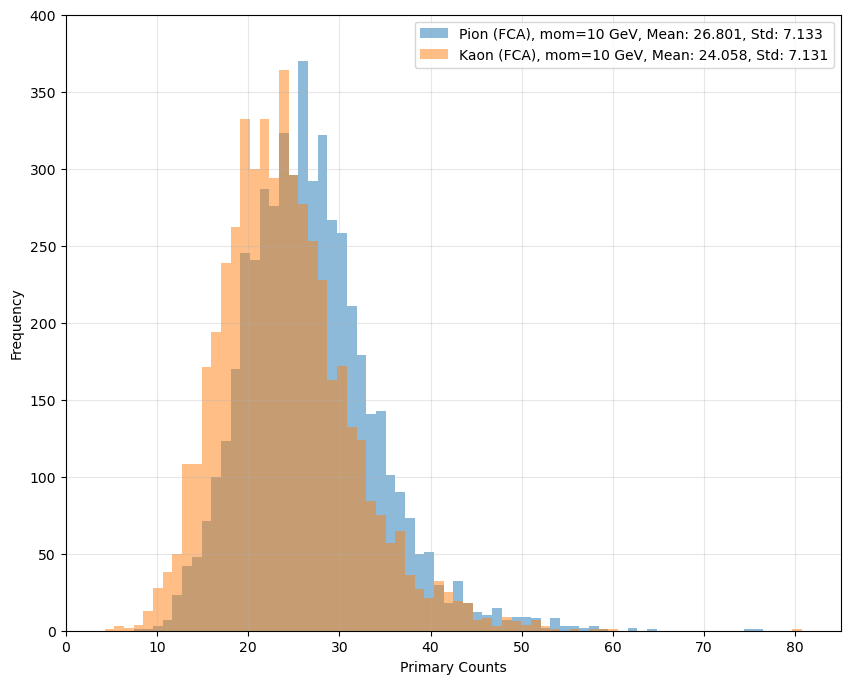

In [54]:
bin_edges = np.linspace(0, 85, 81)  # 50 bins from 0 to 85


plt.figure(figsize=(10, 8))
plt.hist(primary_counts_fixed_pion, bins=bin_edges, alpha=0.5, label=f'Pion (FCA), mom=10 GeV, Mean: {mean_pion:.3f}, Std: {std_pion:.3f}')
plt.hist(primary_counts_fixed_kaon, bins=bin_edges, alpha=0.5, label=f'Kaon (FCA), mom=10 GeV, Mean: {mean_kaon:.3f}, Std: {std_kaon:.3f}')
# plt.hist(primary_counts_fixed_pion_20GeV, bins=bin_edges, alpha=0.5, label=f'Pion (FCA), mom=20 GeV, Mean: {mean_pion_20GeV:.3f}, Std: {std_pion_20GeV:.3f}')
# plt.hist(primary_counts_fixed_kaon_20GeV, bins=bin_edges, alpha=0.5, label=f'Kaon (FCA), mom=20 GeV, Mean: {mean_kaon_20GeV:.3f}, Std: {std_kaon_20GeV:.3f}')
plt.xlabel('Primary Counts')
plt.ylabel('Frequency')
plt.xlim(0,85)
plt.ylim(0,400)
# plt.title('Primary Counts Distribution')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

5000


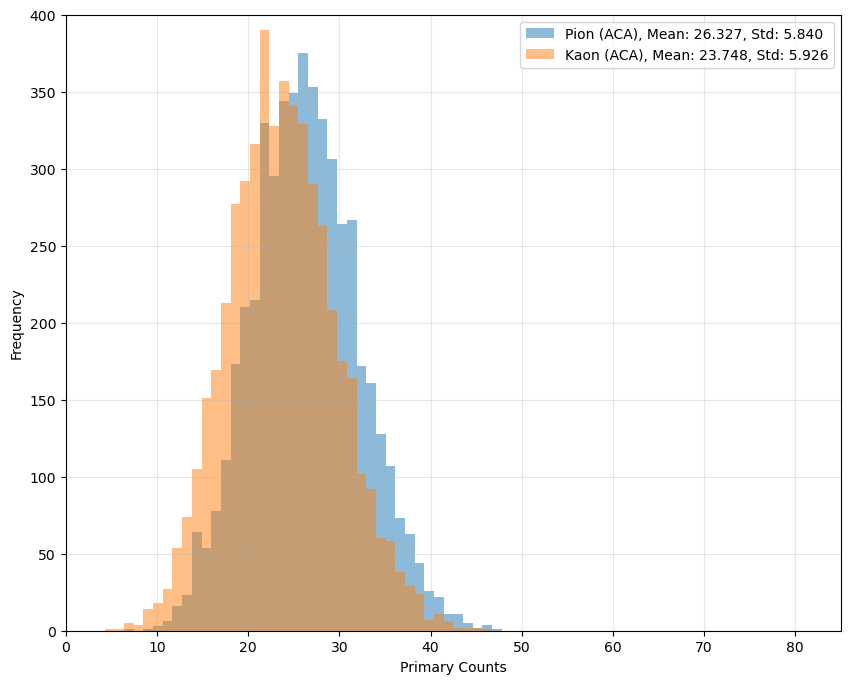

In [50]:
best_params = {
        'r1': {'b': 8, 'c': 0.8, 'd': 2},
        'r2': {'b': 32, 'c': 1.0, 'd': 5},
        'r3': {'b': 67, 'c': 1.4, 'd': 2},
        'r4': {'b': 99, 'c': 0.8, 'd': 1}
    }
    
b_map = {region: params['b'] for region, params in best_params.items()}
c_map = {region: params['c'] for region, params in best_params.items()}
d_map = {region: params['d'] for region, params in best_params.items()}

primary_counts_adaptive_pion = estimate_primary_from_cluster_window_adaptive(detected_peaks_pion, b_map, c_map, d_map)
primary_counts_adaptive_kaon = estimate_primary_from_cluster_window_adaptive(detected_peaks_kaon, b_map, c_map, d_map)

primary_counts_adaptive_pion = np.array(primary_counts_adaptive_pion)
primary_counts_adaptive_kaon = np.array(primary_counts_adaptive_kaon)

mean_pion_adaptive = np.mean(primary_counts_adaptive_pion)
mean_kaon_adaptive = np.mean(primary_counts_adaptive_kaon)
std_pion_adaptive = np.std(primary_counts_adaptive_pion)
std_kaon_adaptive = np.std(primary_counts_adaptive_kaon)

print(len(primary_counts_adaptive_kaon))


plt.figure(figsize=(10, 8))
# plt.hist(primary_counts_fixed_pion, bins=100, alpha=0.5, label=f'Pion (FCA), Mean: {mean_pion:.3f}, Std: {std_pion:.3f}')
# plt.hist(primary_counts_fixed_kaon, bins=100, alpha=0.5, label=f'Kaon (FCA), Mean: {mean_kaon:.3f}, Std: {std_kaon:.3f}')
plt.hist(primary_counts_adaptive_pion, bins=bin_edges, alpha=0.5, label=f'Pion (ACA), Mean: {mean_pion_adaptive:.3f}, Std: {std_pion_adaptive:.3f}')
plt.hist(primary_counts_adaptive_kaon, bins=bin_edges, alpha=0.5, label=f'Kaon (ACA), Mean: {mean_kaon_adaptive:.3f}, Std: {std_kaon_adaptive:.3f}')
plt.xlabel('Primary Counts')
plt.ylabel('Frequency')
plt.xlim(0,85)
plt.ylim(0,400)
# plt.title('Primary Counts Distribution')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Separation Power FCA: [0.37885505 0.38862352 0.38449916 0.36409945 0.36216123 0.33233918
 0.29229119]

Separation Power FCA scaled: [3.99348283 4.09645154 4.05297701 3.83794518 3.81751456 3.5031626
 3.08101962]

Separation Power ACA: [0.45224741 0.46808114 0.43828864 0.42938594 0.41330219 0.3682119
 0.34267554]

Separation Power ACA scaled: [4.76710627 4.93400839 4.61996793 4.52612525 4.3565876  3.8812942
 3.61211737]


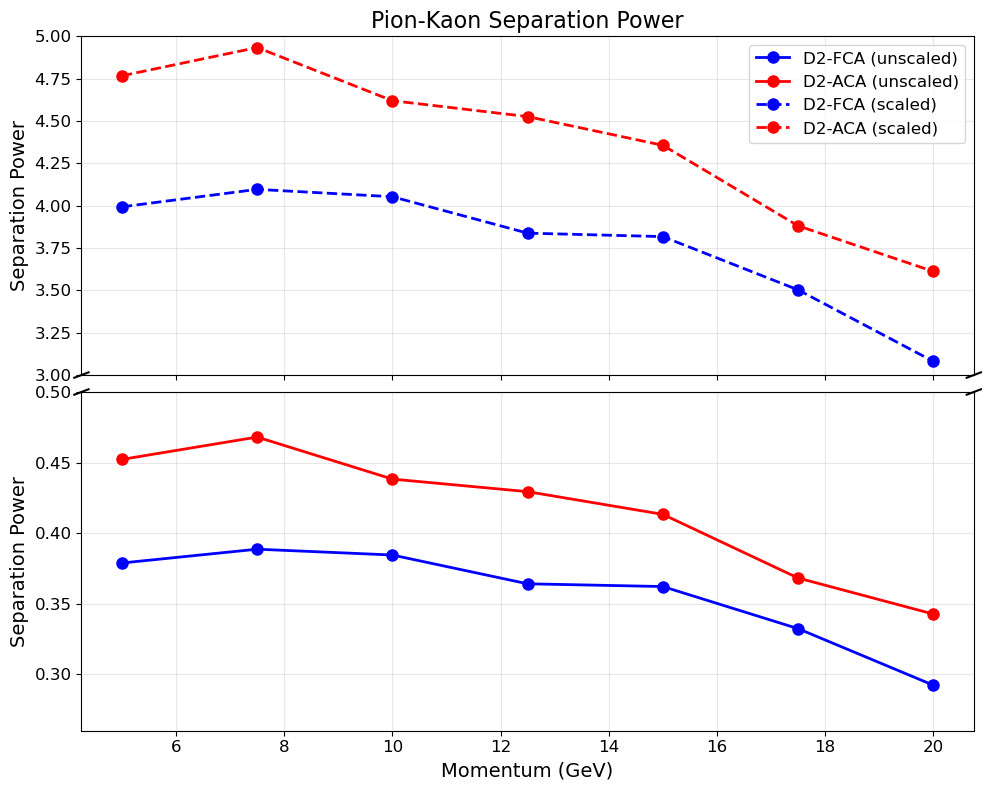

In [16]:
len_scaler = np.sqrt(1000/(9*np.sqrt(1)))
kp_separation_FCA = np.abs(mean_pion - mean_kaon) / ((std_pion + std_kaon)/2)
kp_separation_FCA_scaled = kp_separation_FCA * len_scaler

print(f"\nSeparation Power FCA: {kp_separation_FCA}")
print(f"\nSeparation Power FCA scaled: {kp_separation_FCA_scaled}")

kp_separation_ACA = np.abs(mean_pion_ACA - mean_kaon_ACA) / ((std_pion_ACA + std_kaon_ACA)/2)
kp_separation_ACA_scaled = kp_separation_ACA * len_scaler

print(f"\nSeparation Power ACA: {kp_separation_ACA}")
print(f"\nSeparation Power ACA scaled: {kp_separation_ACA_scaled}")

fig, (ax_upper, ax_lower) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 2]})

ax_upper.plot(pion_momenta, kp_separation_FCA, 'bo-', linewidth=2, markersize=8, label='D2-FCA (unscaled)')
ax_upper.plot(pion_momenta_ACA, kp_separation_ACA, 'ro-', linewidth=2, markersize=8, label='D2-ACA (unscaled)')
ax_upper.plot(pion_momenta, kp_separation_FCA_scaled, 'bo--', linewidth=2, markersize=8, label='D2-FCA (scaled)')
ax_upper.plot(pion_momenta_ACA, kp_separation_ACA_scaled, 'ro--', linewidth=2, markersize=8, label='D2-ACA (scaled)')

ax_upper.set_ylim(3, 5)
ax_upper.grid(True, alpha=0.3)
ax_upper.set_ylabel('Separation Power', fontsize=14)
ax_upper.set_title('Pion-Kaon Separation Power', fontsize=16)
ax_upper.tick_params(labelsize=12)
ax_upper.legend(fontsize=12)

ax_lower.plot(pion_momenta, kp_separation_FCA, 'bo-', linewidth=2, markersize=8)
ax_lower.plot(pion_momenta_ACA, kp_separation_ACA, 'ro-', linewidth=2, markersize=8)
ax_lower.plot(pion_momenta, kp_separation_FCA_scaled, 'bo--', linewidth=2, markersize=8)
ax_lower.plot(pion_momenta_ACA, kp_separation_ACA_scaled, 'ro--', linewidth=2, markersize=8)

ax_lower.set_ylim(0.26, 0.5)
ax_lower.grid(True, alpha=0.3)
ax_lower.set_xlabel('Momentum (GeV)', fontsize=14)
ax_lower.set_ylabel('Separation Power', fontsize=14)
ax_lower.tick_params(labelsize=12)

d = 0.008  
kwargs = dict(transform=ax_upper.transAxes, color='k', clip_on=False)
ax_upper.plot((-d, +d), (-d, +d), **kwargs)       
ax_upper.plot((1 - d, 1 + d), (-d, +d), **kwargs)  

kwargs.update(transform=ax_lower.transAxes)  
ax_lower.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax_lower.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()

In [5]:
T1_D2 = 3 * np.std(testdata['wf_i'][1][2500:2900])
T2_D2 = 0.053320


print("Processing Pion data...")
pion_momenta, mean_pion, std_pion = process_momentum_subsets_D2(
    pion_momentum_subsets, "Pion", T1_D2, T2_D2, max_events=5000
)

print("\nProcessing Kaon data...")
kaon_momenta, mean_kaon, std_kaon = process_momentum_subsets_D2(
    kaon_momentum_subsets, "Kaon", T1_D2, T2_D2, max_events=5000
)

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)

print(f"Pion momenta: {pion_momenta}")
print(f"Pion means:   {mean_pion}")
print(f"Pion stds:    {std_pion}")

print(f"\nKaon momenta: {kaon_momenta}")
print(f"Kaon means:   {mean_kaon}")
print(f"Kaon stds:    {std_kaon}")

Processing Pion data...
Processing Pion momentum 5.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 502.52waveform/s]


  Mean: 33.695, Std: 11.253
Processing Pion momentum 7.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 485.86waveform/s]


  Mean: 35.141, Std: 11.533
Processing Pion momentum 10.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 477.19waveform/s]


  Mean: 35.657, Std: 11.323
Processing Pion momentum 12.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 470.59waveform/s]


  Mean: 36.527, Std: 11.553
Processing Pion momentum 15.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 463.36waveform/s]


  Mean: 36.848, Std: 11.509
Processing Pion momentum 17.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 457.95waveform/s]


  Mean: 37.065, Std: 11.309
Processing Pion momentum 20.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 455.12waveform/s]


  Mean: 37.072, Std: 11.371

Processing Kaon data...
Processing Kaon momentum 5.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 534.03waveform/s]


  Mean: 29.845, Std: 11.520
Processing Kaon momentum 7.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 511.85waveform/s]


  Mean: 31.052, Std: 11.925
Processing Kaon momentum 10.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 511.38waveform/s]


  Mean: 31.697, Std: 11.079
Processing Kaon momentum 12.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 505.75waveform/s]


  Mean: 32.680, Std: 11.177
Processing Kaon momentum 15.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 501.20waveform/s]


  Mean: 33.028, Std: 11.618
Processing Kaon momentum 17.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 493.55waveform/s]


  Mean: 33.555, Std: 11.003
Processing Kaon momentum 20.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 488.80waveform/s]

  Mean: 34.090, Std: 11.349

RESULTS SUMMARY
Pion momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Pion means:   [33.6952 35.1408 35.6566 36.5268 36.8482 37.0654 37.0718]
Pion stds:    [11.25269288 11.53310779 11.32315665 11.55259632 11.50912493 11.30852434
 11.37122002]

Kaon momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Kaon means:   [29.8452 31.0516 31.697  32.6804 33.0282 33.555  34.0904]
Kaon stds:    [11.52019257 11.92460219 11.07906093 11.17664779 11.61796044 11.00333472
 11.34891307]


In [6]:
len_scaler = np.sqrt(1000/(9*np.sqrt(1)))
kp_separation_D2 = np.abs(mean_pion - mean_kaon) / ((std_pion + std_kaon)/2)
kp_separation_D2_scaled = kp_separation_D2 * len_scaler

print(f"\nSeparation Power D2: {kp_separation_D2}")
print(f"\nSeparation Power D2 scaled: {kp_separation_D2_scaled}")


Separation Power D2: [0.3381214  0.34864443 0.35350072 0.33845384 0.33034859 0.31466674
 0.26244565]

Separation Power D2 scaled: [3.56411254 3.67503501 3.72622475 3.56761675 3.48217987 3.3168787
 2.76642001]


In [7]:
T1_D1 = 0.066250
T2_D1 = 0.089000

print("Processing Pion data...")
pion_momenta, mean_pion, std_pion = process_momentum_subsets_D1(
    pion_momentum_subsets, "Pion", T1_D1, T2_D1, max_events=5000
)

print("\nProcessing Kaon data...")
kaon_momenta, mean_kaon, std_kaon = process_momentum_subsets_D1(
    kaon_momentum_subsets, "Kaon", T1_D1, T2_D1, max_events=5000
)

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)

print(f"Pion momenta: {pion_momenta}")
print(f"Pion means:   {mean_pion}")
print(f"Pion stds:    {std_pion}")

print(f"\nKaon momenta: {kaon_momenta}")
print(f"Kaon means:   {mean_kaon}")
print(f"Kaon stds:    {std_kaon}")

Processing Pion data...
Processing Pion momentum 5.0 GeV: 5000 events
  Mean: 34.152, Std: 6.267
Processing Pion momentum 7.5 GeV: 5000 events
  Mean: 34.931, Std: 6.409
Processing Pion momentum 10.0 GeV: 5000 events
  Mean: 35.184, Std: 6.371
Processing Pion momentum 12.5 GeV: 5000 events
  Mean: 35.792, Std: 6.438
Processing Pion momentum 15.0 GeV: 5000 events
  Mean: 35.927, Std: 6.393
Processing Pion momentum 17.5 GeV: 5000 events
  Mean: 35.987, Std: 6.378
Processing Pion momentum 20.0 GeV: 5000 events
  Mean: 35.982, Std: 6.327

Processing Kaon data...
Processing Kaon momentum 5.0 GeV: 5000 events
  Mean: 31.816, Std: 6.210
Processing Kaon momentum 7.5 GeV: 5000 events
  Mean: 32.604, Std: 6.679
Processing Kaon momentum 10.0 GeV: 5000 events
  Mean: 32.951, Std: 6.221
Processing Kaon momentum 12.5 GeV: 5000 events
  Mean: 33.510, Std: 6.281
Processing Kaon momentum 15.0 GeV: 5000 events
  Mean: 33.792, Std: 6.504
Processing Kaon momentum 17.5 GeV: 5000 events
  Mean: 34.001, Std:

In [8]:
len_scaler = np.sqrt(1000/(9*np.sqrt(1)))
kp_separation_D1 = np.abs(mean_pion - mean_kaon) / ((std_pion + std_kaon)/2)
kp_separation_D1_scaled = kp_separation_D1 * len_scaler

print(f"\nSeparation Power D1: {kp_separation_D1}")
print(f"\nSeparation Power D1 scaled: {kp_separation_D1_scaled}")


Separation Power D1: [0.37445177 0.35565675 0.35467919 0.3588471  0.33111777 0.31759188
 0.26197156]

Separation Power D1 scaled: [3.94706824 3.74895134 3.73864689 3.78258053 3.49028777 3.3477124
 2.76142267]


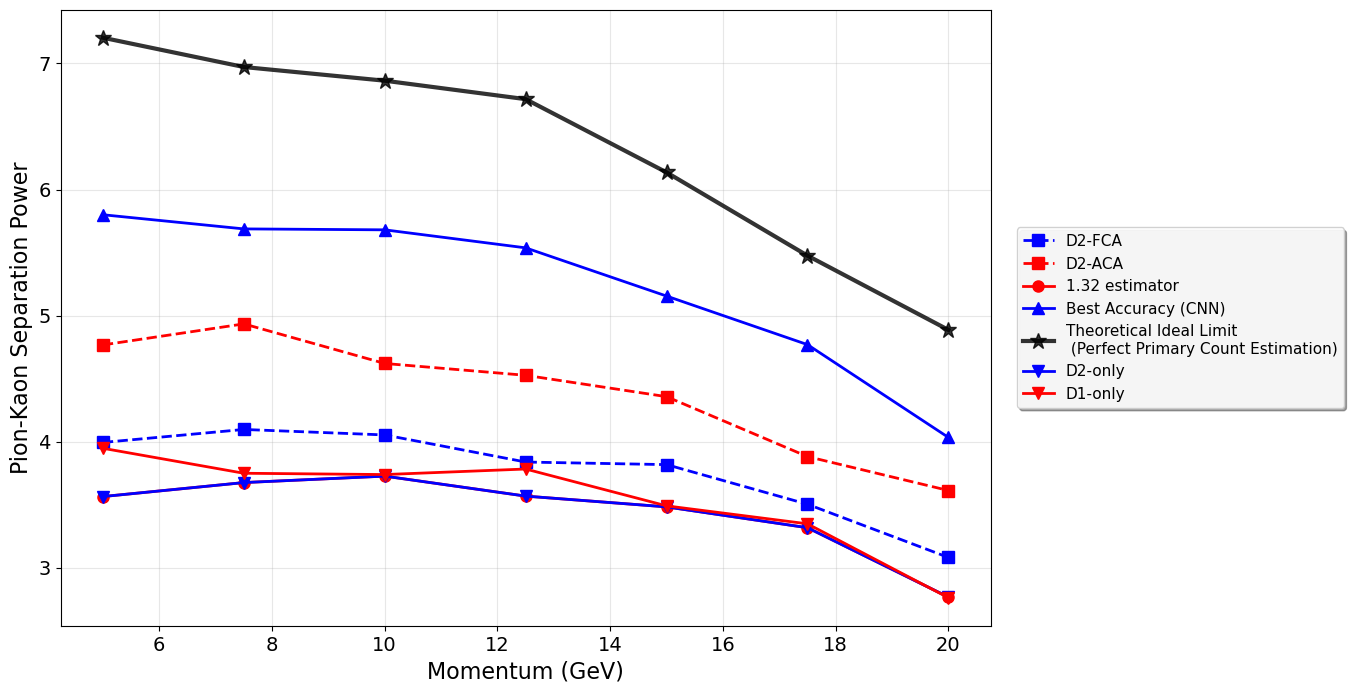

In [15]:
len_scaler = np.sqrt(1000/(9*np.sqrt(1)))

# Data preparation
kp_separation_FCA = [0.3788550456417212, 0.3886235160676578, 0.3844991594392201, 0.36409944875366457, 0.3621612305998233, 0.3323391850742314, 0.29229118560167483]
kp_separation_ACA = [0.4522474099362857, 0.4680811356448874, 0.438288641554179, 0.4293859427150638, 0.41330218919637196, 0.36821189790189696, 0.34267554228994834]
kp_separation_132 = [0.33812139177988726, 0.34864443948540014, 0.3535007319189342, 0.3384538578203419, 0.3303485958833003, 0.31466675301469726, 0.26244565873596676]
kp_separation_ideal = [0.68347969, 0.66142709, 0.65113314, 0.63724259, 0.5821268, 0.51945814, 0.46358263]
kp_separation_D2 = [0.3381214, 0.34864443, 0.35350072, 0.33845384, 0.33034859, 0.31466674, 0.26244565]
kp_separation_D1 = [0.37445177, 0.35565675, 0.35467919, 0.3588471, 0.33111777, 0.31759188, 0.26197156]

kp_separation_best_accuracy = [0.55023503, 0.53958017, 0.53887725, 0.52531976, 0.48902717, 0.4524766, 0.3826344]
kp_separation_best_hardware = [0.4311167, 0.42280653, 0.40144223, 0.3576273, 0.36531562, 0.31653616, 0.29922774]

# Apply scaling
data_sets = [
    kp_separation_FCA, kp_separation_ACA, kp_separation_132, kp_separation_ideal,
    kp_separation_best_accuracy, kp_separation_best_hardware, kp_separation_D2, kp_separation_D1
]

for i, data in enumerate(data_sets):
    data_sets[i] = [value * len_scaler for value in data]

# Unpack scaled data
(kp_separation_FCA, kp_separation_ACA, kp_separation_132, kp_separation_ideal,
 kp_separation_best_accuracy, kp_separation_best_hardware, kp_separation_D2, kp_separation_D1) = data_sets


fontsize_title = 18
fontsize_label = 16
fontsize_ticks = 14
fontsize_legend = 14

plt.figure(figsize=(12, 8))
plt.plot(pion_momenta, kp_separation_FCA, 'bs--', linewidth=2, markersize=8, label='D2-FCA')
plt.plot(pion_momenta, kp_separation_ACA, 'rs--', linewidth=2, markersize=8, label='D2-ACA')
plt.plot(pion_momenta, kp_separation_132, 'ro-', linewidth=2, markersize=8, label='1.32 estimator')
plt.plot(pion_momenta, kp_separation_best_accuracy, 'b^-', linewidth=2, markersize=8, label='Best Accuracy (CNN)')
# plt.plot(pion_momenta, kp_separation_best_hardware, 'g^-', linewidth=2, markersize=8, label='Best Hardware (DNN)')
plt.plot(pion_momenta, kp_separation_ideal, 'k*-', linewidth=3, markersize=12, 
         label='Theoretical Ideal Limit \n (Perfect Primary Count Estimation)', alpha=0.8)
plt.plot(pion_momenta, kp_separation_D2, 'bv-', linewidth=2, markersize=8, label='D2-only')
plt.plot(pion_momenta, kp_separation_D1, 'rv-', linewidth=2, markersize=8, label='D1-only')
plt.xlabel('Momentum (GeV)', fontsize=fontsize_label)
plt.ylabel('Pion-Kaon Separation Power', fontsize=fontsize_label)
# plt.title('Pion-Kaon Separation Power', fontsize=fontsize_title)
plt.grid(True, alpha=0.3)
legend = plt.legend(fontsize=11, loc='center left', bbox_to_anchor=(1.02, 0.5), 
                   frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.show()